# Introdução

Este desafio visa a criação de uma solução para identificação de fraudes.

Dentre as principais etapas do processo, estão:

 - Análise exploratória
 - Criação de Features
 - Criação de modelos
 - Verificação da performance dos modelos

O dataset pode ser encontrado em:
https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view?usp=sharing

Features:
- step - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

- type - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

- amount - Quantia: total que foi transacionado;

- nameOrig - ClienteOrigem: cliente que iniciou a transação

- oldbalanceOrg - SaldoInicialOrigem: saldo da conta de origem antes da transação;

- newbalanceOrig - SaldoFinalOrigem: saldo da conta de origem após a transação;

- nameDest - ClienteDestino: cliente de destino da transação;

- oldbalanceDest - SaldoInicialDestino: saldo da conta de destino antes da transação;

- newbalanceDest - SaldoFinalDestino: saldo da conta de destino após a transação;

- isFraud - ÉFraude: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- isFlaggedFraud - SinalizadaComoFraude: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

## Instalação do RAPIDS

# Importando os Dados

In [88]:
# importando as bibliotecas necessarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray

from datetime import datetime as dt
from datetime import timedelta as td

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [89]:
# importando o dataset direto do Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [90]:
# impmortando o dataset de fraudes
df = pd.read_csv('/content/gdrive/My Drive/Curso TERA/Desafio Classificação - Fraude/fraud_detection_dataset.csv')

In [91]:
# verificando o dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [92]:
# informações básicas do dataset
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Não há nenhum dado faltante deste dataset

In [93]:
# estatísticas iniciais
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [94]:
# tamanho do dataset
df.shape

(6362620, 11)

# EDA

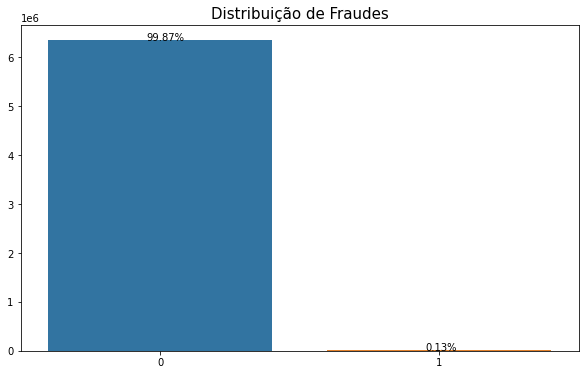

In [95]:
# verificando a distribuição de fraudes
plt.figure(figsize = (10,6))

ax = sns.countplot(df.isFraud)
ax.set_title('Distribuição de Fraudes', fontsize = 15)
ax.set_xlabel("")
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.isFraud)), (p.get_x()+ 0.35, p.get_height()+1000))

Nota-se que 0,13% das transações são fraudulentas.

Percentualmente é baixo, porém pode significar um prejuízo muito grande se não detectados

Agora, vamos ver como o mecanismo de detecção de fraudes do banco performa.

Primeiro, analisamos o total de indicação de fraude que foi realizado

In [96]:
# total de "indicação de fraude" pelo banco
print('Indicações de Fraude pelo banco: {} ({}%)'.format(df.isFlaggedFraud.sum(),round((df.isFlaggedFraud.sum()/df.isFraud.sum()*100),2)))
print('Quantidade de Fraudes reais:', df.isFraud.sum())

Indicações de Fraude pelo banco: 16 (0.19%)
Quantidade de Fraudes reais: 8213


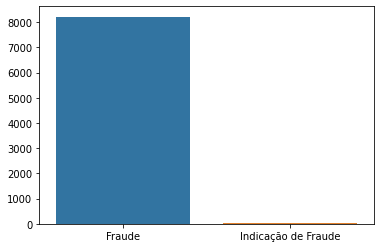

In [97]:
# comparação entre fraudes e indicações de fraudes
ax = sns.barplot(x = ['Fraude', 'Indicação de Fraude'],
                 y = [df.isFraud.sum(), df.isFlaggedFraud.sum()])

Apenas 0,19% das Indicações de Fraude pelo banco (transações acima de 200.000) eram realmente fraudes. Isso mostra que o sistema do banco é muito ineficiente

## Distribuição das fraudes no tempo

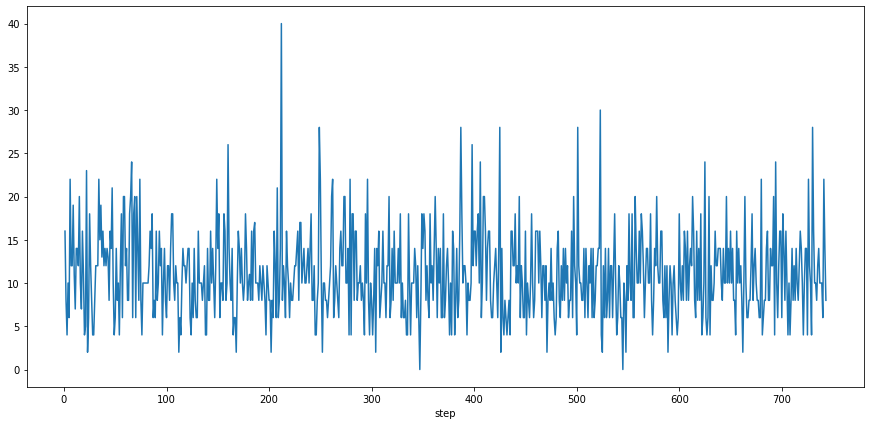

In [98]:
# verificando fraude no tempo
plt.figure(figsize=(15,7))
df.groupby('step')['isFraud'].sum().plot()

In [99]:
df.groupby('step')['isFraud'].count()[:50]

step
1      2708
2      1014
3       552
4       565
5       665
6      1660
7      6837
8     21097
9     37628
10    35991
11    37241
12    36153
13    37515
14    41485
15    44609
16    42471
17    43361
18    49579
19    51352
20    40625
21    19152
22    12635
23     6144
24     3216
25     1598
26      440
27       41
28        4
29        4
30        8
31       12
32       12
33    23616
34    30904
35    29157
36    39774
37    34000
38    31453
39    23391
40    34270
41    36348
42    41304
43    45060
44    38523
45    18500
46    12445
47     8681
48     5693
49      764
50        6
Name: isFraud, dtype: int64

In [100]:
df.groupby('step')['isFraud'].sum()[:50]

step
1     16
2      8
3      4
4     10
5      6
6     22
7     12
8     12
9     19
10    11
11     7
12    14
13    14
14    12
15    20
16    10
17     7
18    16
19    11
20     4
21     5
22    23
23     2
24     6
25    18
26    12
27     8
28     4
29     4
30     8
31    12
32    12
33    12
34    22
35    15
36    19
37    13
38    16
39    12
40    14
41    12
42    14
43    13
44     8
45    16
46    14
47    21
48    10
49     4
50     6
Name: isFraud, dtype: int64

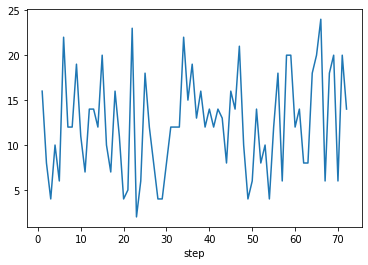

In [101]:
df.groupby('step')['isFraud'].sum()[:72].plot()

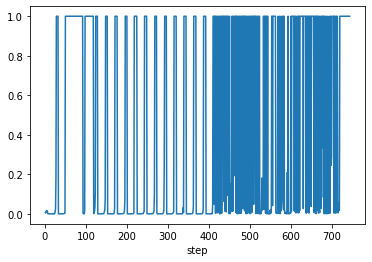

In [102]:
(df.groupby('step')['isFraud'].sum()/df.groupby('step')['isFraud'].count()).plot()

In [103]:
(df.groupby('step')['isFraud'].sum()/df.groupby('step')['isFraud'].count())[:50]

step
1     0.005908
2     0.007890
3     0.007246
4     0.017699
5     0.009023
6     0.013253
7     0.001755
8     0.000569
9     0.000505
10    0.000306
11    0.000188
12    0.000387
13    0.000373
14    0.000289
15    0.000448
16    0.000235
17    0.000161
18    0.000323
19    0.000214
20    0.000098
21    0.000261
22    0.001820
23    0.000326
24    0.001866
25    0.011264
26    0.027273
27    0.195122
28    1.000000
29    1.000000
30    1.000000
31    1.000000
32    1.000000
33    0.000508
34    0.000712
35    0.000514
36    0.000478
37    0.000382
38    0.000509
39    0.000513
40    0.000409
41    0.000330
42    0.000339
43    0.000289
44    0.000208
45    0.000865
46    0.001125
47    0.002419
48    0.001757
49    0.005236
50    1.000000
Name: isFraud, dtype: float64

Parece haver uma oscilação de fraudes durante as horas..

Isso pode ser um indicativo para criarmos uma nova feature que indique a hora do dia.

## Distribuição da quantidade transacionada

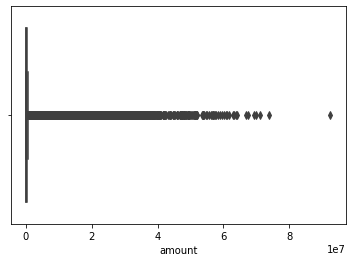

In [104]:
# Plot da qtd da transação
# dividida por fraude/não fraude

sns.boxplot(df.amount)

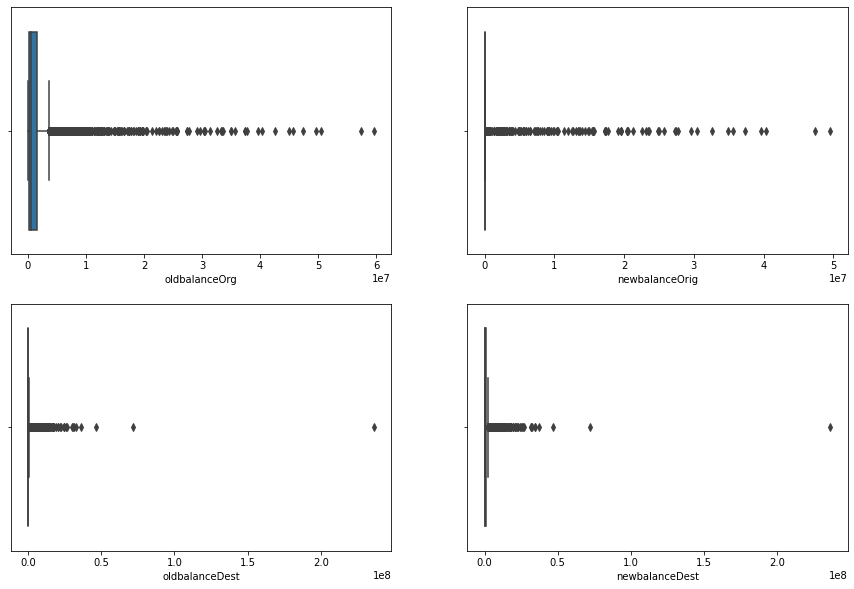

In [105]:
# verificando distribuição das contas origem e destino
# quando FRAUDE
features_contas = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

fig = plt.figure(figsize=(15, 10))

for column in features_contas:
  ax = fig.add_subplot(2, 2, features_contas.index(column)+1)
  sns.boxplot(df[df.isFraud==1][column])

As quantidades das transações, assim como saldos nas contas origem e destino possuem curvas de distribuição assimétricas para a direita.

Todas possuem outliers.

## Tipos de transações

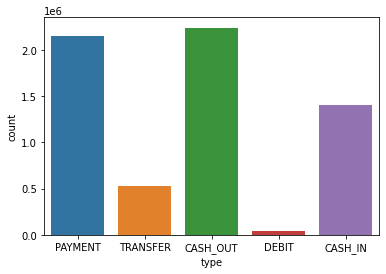

In [106]:
# Quantidade de tipos de pagamentos
sns.countplot(df['type'])

In [107]:
df[df['isFraud']==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

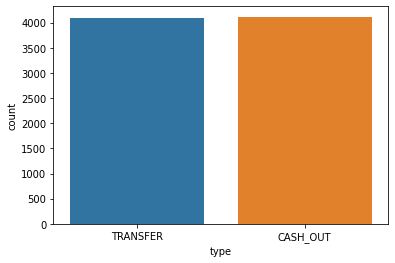

In [108]:
# Tipos de pagamentos dentre as fraudes
sns.countplot(df[df['isFraud']==1]['type'])

Só houve fraudes em transferências e cash out

## Avaliação dos Nomes

In [109]:
# quantidade de cada nome da lista de origem
df.nameOrig.value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [110]:
# quantidade de cada nome da lista de destino
df.nameDest.value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

Há quantidades muito maiores para o mesmo nome de destino do que de origem

Podemos analisar os nomes de destino um pouco mais a fundo

### Quantas transações existiram para os destinatários das transações fraudulentas?

In [111]:
df[df.isFraud==1]['nameDest'].value_counts()

C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
              ..
C317811789     1
C24324787      1
C1053414206    1
C2013070624    1
C873221189     1
Name: nameDest, Length: 8169, dtype: int64

Para o mesmo destinatário, houve poucas repetições de nomes, quando a transação é fraudulenta.

Porém, pode ter havido transações normais para esses destinatários, antes de haver a fraude?

Vamos contar o total das transações para esses destinatários

In [112]:
df_Quant_Trans_Dest = pd.DataFrame({'names_Dest': df.nameDest.value_counts().index.tolist(),
                                    'quantTrans': df.nameDest.value_counts()}).reset_index()

In [113]:
name_dest_fraudes = df[df.isFraud==1]['nameDest'].value_counts().index.tolist()

In [114]:
df_Quant_Trans_Dest_Frauds = df_Quant_Trans_Dest[df_Quant_Trans_Dest['names_Dest'].isin(name_dest_fraudes)].drop('index', axis=1)

In [115]:
df_Quant_Trans_Dest_Frauds.reset_index(inplace=True)

In [116]:
df_Quant_Trans_Dest_Frauds.drop('index', axis=1, inplace=True)

In [117]:
df_Quant_Trans_Dest_Frauds

,names_Dest,quantTrans
0,C716083600,89
1,C667346055,86
2,C932583850,82
3,C766681183,80
4,C803116137,77
...,...,...
8164,C2100877994,1
8165,C825722694,1
8166,C195893407,1
8167,C2033959349,1


Alguns dos destinatários que das transações fraudulentas, fizeram muitas transações no período. Dessas, apenas 1 ou 2 foram fraudulentas.

Vamos ver a distribuição da quantidade de transações dos Destinatários que tiveram pelo menos uma transação fraudulenta.

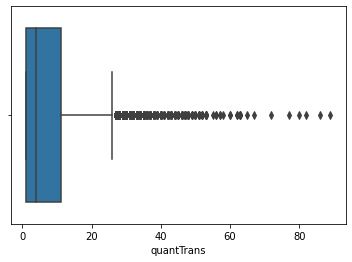

In [118]:
# boxplot dos transalções dos destinatários
# que tiveram ao menos em uma fraudulenta

sns.boxplot(df_Quant_Trans_Dest_Frauds['quantTrans'])

In [119]:
print('50% dos dados estão entre {} e {}'.format(df_Quant_Trans_Dest_Frauds['quantTrans'].quantile(.25),
                                                 df_Quant_Trans_Dest_Frauds['quantTrans'].quantile(.75)))

50% dos dados estão entre 1.0 e 11.0


Essa distribuição é diferenta daquela com os outros destinatários? (aqueles que não estiveram em nenhuma transação fraudulenta)

In [120]:
# destinatários que não estiveram em transações fraudulentas
df_Quant_Trans_Dest_NFrauds = df_Quant_Trans_Dest[~df_Quant_Trans_Dest['names_Dest'].isin(name_dest_fraudes)].drop('index', axis=1)

In [121]:
df_Quant_Trans_Dest_NFrauds.reset_index(inplace=True)

In [122]:
df_Quant_Trans_Dest_NFrauds.drop('index', axis=1, inplace=True)

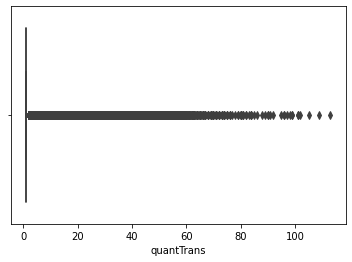

In [123]:
# boxplot dos transalções dos destinatários
# que NÃO estiveram em nenhuma transação fraudulenta
sns.boxplot(df_Quant_Trans_Dest_NFrauds['quantTrans'])

In [124]:
print('50% dos dados estão entre {} e {}'.format(df_Quant_Trans_Dest_NFrauds['quantTrans'].quantile(.25),
                                                 df_Quant_Trans_Dest_NFrauds['quantTrans'].quantile(.75)))

50% dos dados estão entre 1.0 e 1.0


Dentre os destinatários que estiveram em transações fraudulentas, e aqueles que não estiveram, houve uma diferença entre as distribuições das quantidades de transações.

Isso pode significar que criar uma feature com a quantidade de transações pode ser vantajoso

### Quantas transações existiram para os nomes de Origem das transações fraudulentas?

In [125]:
# Criando um DF para nomes de origem em transações fraudulentas
df_Quant_Trans_Orig = pd.DataFrame({'names_Orig': df.nameOrig.value_counts().index.tolist(),
                                    'quantTrans': df.nameOrig.value_counts()}).reset_index()

In [126]:
# lista com nomes de origem que estiveram em operações fraudulentas
name_orig_fraudes = df[df.isFraud==1]['nameOrig'].value_counts().index.tolist()

In [127]:
df_Quant_Trans_Orig_Frauds = df_Quant_Trans_Orig[df_Quant_Trans_Orig['names_Orig'].isin(name_orig_fraudes)].drop('index', axis=1)

In [128]:
df_Quant_Trans_Orig_Frauds.reset_index(inplace=True)

In [129]:
df_Quant_Trans_Orig_Frauds.drop('index', axis = 1, inplace=True)

In [130]:
df_Quant_Trans_Orig_Frauds

,names_Orig,quantTrans
0,C357911107,2
1,C1882162040,2
2,C171834973,2
3,C1885333477,2
4,C803411135,2
...,...,...
8208,C1234321469,1
8209,C1246119241,1
8210,C949325212,1
8211,C1015989725,1


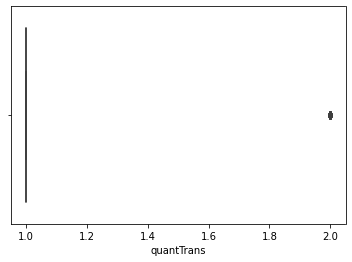

In [131]:
# boxplot dos transações dos nomes de origem
# que tiveram ao menos em uma fraudulenta

sns.boxplot(df_Quant_Trans_Orig_Frauds['quantTrans'])

Agora, para aqueles nomes de origem que não estiveram em nenhuma transação fraudulenta

In [132]:
# nomes de origem que não estiveram em transações fraudulentas
df_Quant_Trans_Orig_NFrauds = df_Quant_Trans_Orig[~df_Quant_Trans_Orig['names_Orig'].isin(name_orig_fraudes)].drop('index', axis=1)

In [133]:
df_Quant_Trans_Orig_NFrauds.reset_index(inplace=True)

In [134]:
df_Quant_Trans_Orig_NFrauds.drop('index', axis=1, inplace=True)

In [135]:
df_Quant_Trans_Orig_NFrauds

,names_Orig,quantTrans
0,C1902386530,3
1,C363736674,3
2,C545315117,3
3,C724452879,3
4,C1784010646,3
...,...,...
6345089,C740782868,1
6345090,C98968405,1
6345091,C720209255,1
6345092,C1567523029,1


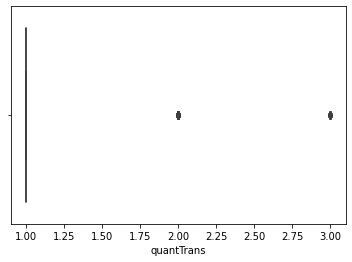

In [136]:
sns.boxplot(df_Quant_Trans_Orig_NFrauds['quantTrans'])

Para nomes de origem, parece fazer menos sentido criar uma feature com quantidade de transações. Isso porque tanto para transações fraudulentas, como não fraudulentas, a distribuição é parecida

## Correlação no dataset

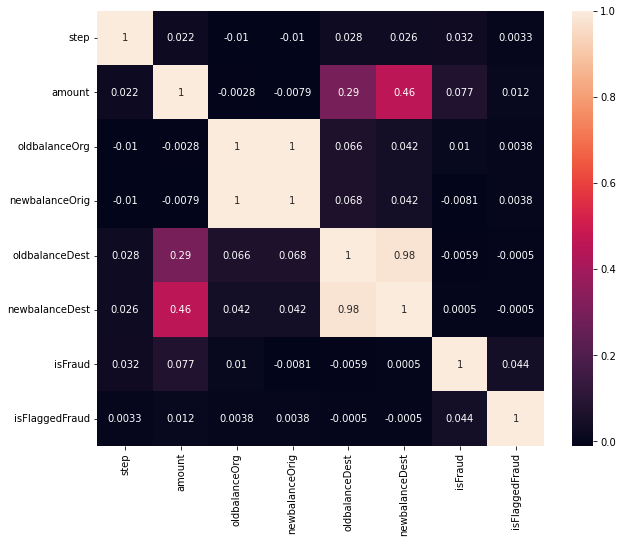

In [137]:
# plotando o heatmap de correlação no dataset
plt.figure(figsize=(10,8))
sns.heatmap(round(df.corr(),4),
            annot=True)

Da forma que estão, as features numéricas não possuem correlação linear forte com as fraudes.

Criaremos algumas features e rodaremos nossos modelos para ver como performam

# Feature Engineering

A partir do nosso EDA, vimos que há uma oscilação das fraudes no decorrer do tempo.

Então, primeiro vamos separar esse tempo nas horas do dia, ou seja, de 1 a 24.

## Feature de Horas

In [138]:
# criando uma cópia do dataset
df_copia = df.copy()

In [139]:
# criando um dataframe de datas
# para transformar o nosso step em horas

data_inicio = dt(2021, 1, 1, 0, 0, 0) # data e horas de inicio da nossa contagem
datas = [data_inicio] # lista para armazenar as datas

# armazena as datas em uma lista
for i in range(1, 743):
    data_inicio += td(seconds=3600)
    datas.append(data_inicio)

df_datas = pd.DataFrame({'dates': datas})
df_datas['step'] = df_datas.index+1
df_datas['hour'] = df_datas['dates'].dt.hour
# Remove the datetime object column.
df_datas.drop(['dates'], inplace=True, axis=1)

In [140]:
df_datas

,step,hour
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
738,739,18
739,740,19
740,741,20
741,742,21


In [141]:
# unindo nosso dataset inicial com esse de datas, pelo step

df_com_horas = pd.merge(df_copia, df_datas, on=['step'], how='left')

In [142]:
df_com_horas

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,22
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,22
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,22
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,22


## Nomes Destinatários

In [143]:
# criando df com quantidade de operações dos destinatários no último mês
df_copia_nomes_dest = pd.DataFrame({'nameDest': df_copia['nameDest'].value_counts().index,
                                    'quantTrans': df_copia['nameDest'].value_counts()})

In [144]:
# criando feature de quantidade de operações por destinatário
df_novas_features = pd.merge(df_com_horas, df_copia_nomes_dest, on=['nameDest'], how='left')

In [145]:
df_novas_features = df_novas_features[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
                                       'nameDest', 'oldbalanceDest', 'newbalanceDest',
                                       'hour', 'quantTrans', 'isFlaggedFraud', 'isFraud']]

In [146]:
df_novas_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,hour,quantTrans,isFlaggedFraud,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,44,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,41,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,22,2,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,22,1,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,22,3,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,22,1,0,1


## Verificando Correlações da nova Feature Horas

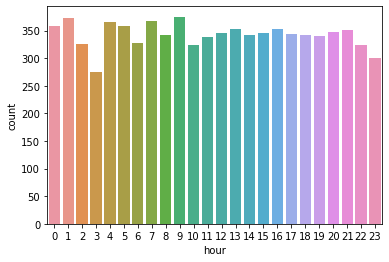

In [147]:
# horas do dia vs fraudes
sns.countplot(df_novas_features[df_novas_features['isFraud']==1]['hour'])

De forma geral, a quantidade de fraudes durante o dia é constante. Há diminuição mais consideravel nas hora 3 e 23. 

Agora, vamos ver o total de operações durante o dia

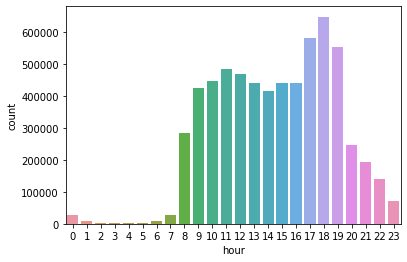

In [148]:
# horas do dia vs operações
sns.countplot(df_novas_features['hour'])

Há muito mais transações durante as horas 9 e 19.

O que indica uma participação percentual das fraudes muito maior em certas horas do dia. Vamos analisar

In [149]:
df_horas_percentual_fraudes = pd.DataFrame({'hour': df_novas_features['hour'].unique(),
                                           'total':df_novas_features.groupby('hour')['isFraud'].count(),
                                           'frauds': df_novas_features.groupby('hour')['isFraud'].sum()})

In [150]:
df_horas_percentual_fraudes['frauds_ratio'] = round(df_horas_percentual_fraudes['frauds']/df_horas_percentual_fraudes['total'],2)

In [151]:
df_horas_percentual_fraudes.drop('hour', axis=1, inplace=True)

In [152]:
df_horas_percentual_fraudes

,total,frauds,frauds_ratio
hour,,,
0,27111,358,0.01
1,9018,372,0.04
2,2007,326,0.16
3,1241,274,0.22
4,1641,366,0.22
5,3420,358,0.10
6,8988,328,0.04
7,26915,368,0.01
8,283518,341,0.00


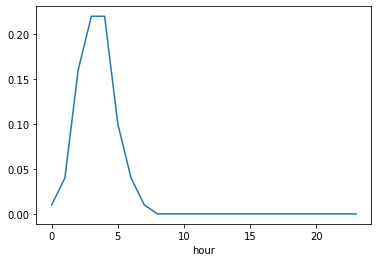

In [153]:
df_horas_percentual_fraudes.frauds_ratio.plot()

As 8 primeiras horas são mais propensas a terem fraudes.

Assim, vamos dividir nossas horas em [0,7] -> [0] e [8,23] -> [1] e criar uma nova feature!

In [154]:
df_horas_divididas = pd.DataFrame({'hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                   'hour_class': [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]})

In [155]:
df_horas_divididas

,hour,hour_class
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,0
9,9,0


In [156]:
df_novas_features = pd.merge(df_novas_features,df_horas_divididas,on=['hour'], how='left')

In [157]:
df_novas_features = df_novas_features[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'hour', 'hour_class','quantTrans',
       'isFlaggedFraud', 'isFraud']]

In [158]:
df_novas_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,hour,hour_class,quantTrans,isFlaggedFraud,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1,44,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,41,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,22,0,2,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,22,0,1,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,22,0,3,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,22,0,1,0,1


# Pre Processamento

In [159]:
# Separando em treino, teste e validação

def treino_teste_validacao(X, y): # X é o df de X e y é a series de y
  X = X.copy()

  # Primeiro, separando em treino e test_val (teste + validação)
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.30, random_state = 42)

  # Agora, separando test_val em test e valid
  X_test, X_valid, y_test, y_valid = train_test_split(X_test_val, y_test_val, test_size = 0.50, random_state = 42)

  return X_train, X_test, X_valid, y_train, y_test, y_valid

In [160]:
def preprocessing(X_train, X_valid, X_test, y_train):

  # Preprocessamento categóricas - codificando com OrdinalEncoder
  oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
  X_train[features_oe] = oe.fit_transform(X_train[features_oe])
  X_valid[features_oe] = oe.transform(X_valid[features_oe])
  X_test[features_oe] = oe.transform(X_test[features_oe])

  return X_train, X_valid, X_test

In [161]:
# separando em treino, teste e validação
# vamos dropar nameOrig e nameDest também
# nameOrig -> há muitas categorias diferentes
# nameDest -> há muitas categorias diferentes e criamos uma feature relacionada a essa
X = df_novas_features.drop(['isFraud','nameOrig','nameDest'], axis=1)
y = df_novas_features.isFraud

X_train, X_test, X_valid, y_train, y_test, y_valid = treino_teste_validacao(X=X, y=y)

In [162]:
print('X treino:',X_train.shape)
print('y treino:',y_train.shape)
print('X validação:',X_valid.shape)
print('y valiação:',y_valid.shape)
print('X teste:',X_test.shape)
print('y teste:',y_test.shape)

X treino: (4453834, 11)
y treino: (4453834,)
X validação: (954393, 11)
y valiação: (954393,)
X teste: (954393, 11)
y teste: (954393,)


In [163]:
# pre processamento do dataset
features_oe = ['type']
X_train, X_valid, X_test = preprocessing(X_train.copy(), X_valid.copy(), X_test.copy(), y_train)

In [164]:
X_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 2408104 to 1692743
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            4453834 non-null  int64  
 1   type            4453834 non-null  float64
 2   amount          4453834 non-null  float64
 3   oldbalanceOrg   4453834 non-null  float64
 4   newbalanceOrig  4453834 non-null  float64
 5   oldbalanceDest  4453834 non-null  float64
 6   newbalanceDest  4453834 non-null  float64
 7   hour            4453834 non-null  int64  
 8   hour_class      4453834 non-null  int64  
 9   quantTrans      4453834 non-null  int64  
 10  isFlaggedFraud  4453834 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 407.8 MB


In [165]:
X_train

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,hour_class,quantTrans,isFlaggedFraud
2408104,202,0.0,26771.98,27521.00,54292.98,7175503.03,7148731.05,9,0,17,0
662430,36,1.0,344879.65,0.00,0.00,3731846.57,4076726.22,11,0,45,0
496595,20,4.0,1862607.84,0.00,0.00,3329828.01,4913631.27,19,0,31,0
5053741,354,3.0,37739.35,66684.93,28945.58,0.00,0.00,17,0,1,0
755621,38,1.0,376055.13,22501.00,0.00,182350.43,558405.55,13,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...
1570006,155,0.0,129715.85,5054252.83,5183968.68,246692.94,116977.09,10,0,12,0
2234489,186,3.0,2459.70,0.00,0.00,0.00,0.00,17,0,1,0
4926484,350,1.0,10579.16,59279.00,48699.84,322754.16,333333.32,13,0,4,0
4304572,307,1.0,73020.76,20289.00,0.00,256102.84,329123.61,18,0,8,0


# Modelo Baseline (dataset desblanceado)

Vamos trabalhar com 3 modelos aqui: Logistic Regression, Random Forest e XGBoost

Para avaliação de cada modelo, vou usar as métricas recall, precision, accuracy e f1

In [166]:
def cross_val_models(X_train, y_train, models):
  cross_val_rec = []
  cross_val_prec = []
  cross_val_accur = []
  cross_val_f1 = []

  for model in models:
    cross_val_rec.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'recall').mean())
    cross_val_prec.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'precision').mean())
    cross_val_accur.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy').mean())
    cross_val_f1.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1').mean())

  df_cross_val = pd.DataFrame({'Recall': cross_val_rec,
                                  'Precision': cross_val_prec,
                                  'Accuracy': cross_val_accur,
                                  'f1': cross_val_f1},
                                  index = ['Logistic Regression', 'Random Forest', 'XGBoost'])
  return df_cross_val

In [178]:
# importando as bibliotecas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#from cuml.linear_model import LogisticRegression as cuml_lr
#from cuml.ensemble import RandomForestClassifier as cuml_rfc

In [168]:
# Modelos de ML
lr = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

Rodando com RandomForest e verificando as métricas precision, recall e f1

In [ ]:
rfc.fit(X_train, y_train)
y_pred_train_rfc_baseline = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.99      0.82      0.90      1208

    accuracy                           1.00    954393
   macro avg       0.99      0.91      0.95    954393
weighted avg       1.00      1.00      1.00    954393



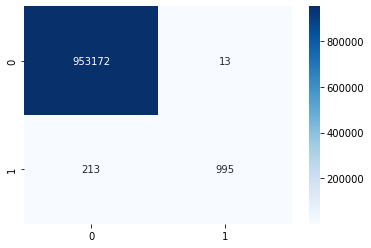

In [ ]:
# criando a matriz de confusão para o baseline
ax = sns.heatmap(confusion_matrix(y_valid, y_pred_train_rfc_baseline),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

# Modelo com Undersampling

Vamos utilizar o método de undersampling e rodar o Random Forest, para verificar como ficam as métricas em comparação ao baseline.

Como o dataset é grande, teoricamente não teremos grandes problemas com essa técnica.Além disso, como o dataset vai diminuir consideravelmente, podemos testar com outras técnicas, como logistic regression e XGBoost.

Para isso, vou utilizar a função cross_val_models

In [169]:
# importando a biblioteca de undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [170]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Dataset após undersampling: %s' % Counter(y_train_rus))

Dataset após undersampling: Counter({0: 5778, 1: 5778})


Agora, rodando os três modelos, para dataset de treinamento balanceado com undersample, e utilizando CrossVal


In [171]:
lr = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

models = [lr, rfc, xgb]

cross_val_models(X_train_rus, y_train_rus, models=models)

,Recall,Precision,Accuracy,f1
Logistic Regression,0.901005,0.909729,0.905591,0.905224
Random Forest,0.994462,0.986464,0.990395,0.990440
XGBoost,0.993597,0.983753,0.988578,0.988641


Nesse caso,houve leve vantagem para o modelo de Random Forest.

Assim, vamos seguir com ele

## Modelo RFC em validação

In [172]:
# modelo rfc com dados undersampled em validação
rfc.fit(X_train_rus, y_train_rus)
y_pred_train_rfc_rus = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_rus))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    953185
           1       0.08      1.00      0.15      1208

    accuracy                           0.99    954393
   macro avg       0.54      0.99      0.57    954393
weighted avg       1.00      0.99      0.99    954393



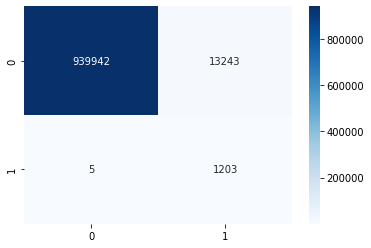

In [173]:
# criando a matriz de confusão para o modelo rfc com undersampled
ax = sns.heatmap(confusion_matrix(y_valid, y_pred_train_rfc_rus),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

Como perdemos muitos dados durante o undersampling, isso pode ter prejudicado nossas métricas com os dados de valiação.

Dessa vez não será possível utilizar o modelo de oversampling, devido aos recursos computacionais.

Assim, vamos continuar somente com o datset desbalanceado, e ajustando os hiperparâmetros

# Modelo RFC desbalanceado- Otimização Hiperparâmetros

In [ ]:
rfc = RandomForestClassifier(n_estimators=75,
                             max_depth=20,
                             max_features=0.25,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred_train_rfc_v1 = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_v1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.99      0.81      0.89      1208

    accuracy                           1.00    954393
   macro avg       1.00      0.91      0.95    954393
weighted avg       1.00      1.00      1.00    954393



In [174]:
rfc = RandomForestClassifier(n_estimators=150,
                             max_depth=30,
                             max_features=0.5,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred_train_rfc_v1 = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_v1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.98      0.84      0.91      1208

    accuracy                           1.00    954393
   macro avg       0.99      0.92      0.95    954393
weighted avg       1.00      1.00      1.00    954393



Não foi possível rodar a otimização dos parâmetros com o GridSearchCV.

Assim, vamos utilizar os parâmetros que deram melhores resultados:
 - n_estimators=150,
 - max_depth=30,
 - max_features=0.5

# Modelo com Undersampling - TESTE

In [176]:
y_pred_train_rfc_teste = rfc.predict(X_test)
print(classification_report(y_test, y_pred_train_rfc_teste))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953166
           1       0.98      0.83      0.89      1227

    accuracy                           1.00    954393
   macro avg       0.99      0.91      0.95    954393
weighted avg       1.00      1.00      1.00    954393



## ROC AUC - TESTE

Random Forest Classifier TESTE score: 99.98
------------------------------------------------------------------------------------------


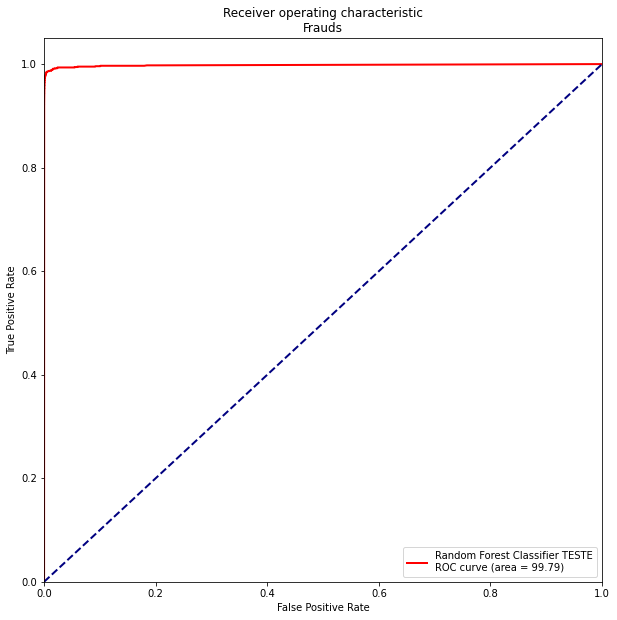

In [179]:
y_proba_teste_rfc = rfc.predict_proba(X_test)
y_proba_teste_rfc = y_proba_teste_rfc[:, 1]

print('Random Forest Classifier TESTE score:',
      round(rfc.score(X_test, y_test)*100,2))
print('-'*90)

roc_auc_rfc = roc_auc_score(y_test, y_proba_teste_rfc)

fpr_rfc, tpr_rfc, thresold_rfc = roc_curve(y_test, y_proba_teste_rfc)


plt.figure(figsize = (10,10))

plt.plot(fpr_rfc, tpr_rfc, color='Red',
        lw=2, label='Random Forest Classifier TESTE\nROC curve (area = %0.2f)' % round(roc_auc_score(y_test, y_proba_teste_rfc)*100,2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic\nFrauds')
plt.legend(loc="lower right")
plt.show()

## Otimização de ganhos

Uma outra abordagem que podemos ter é definir os possíveis ganhos para a área de negócio.

Para isso, vamos definir valores para cada acerto ou erro do nosso modelo.

Vamos usar os seguintes valores:
TN = 10
FP = -10
FN = -50
TP = 10

In [ ]:
ganho_tn = 10
ganho_fp = -10
ganho_fn = -50
ganho_tp = 10

ganho_total = []
soma_ganho = 0

# definindo os ganhos, para cada valor de threshold associado
for i in range(len(thresold_rfc)):
    # valor de y previsto para determinado valor de threshold
    y_proba_teste_rfc = (rfc.predict_proba(X_test)[:,1] >= thresold_rfc[i]).astype(bool) 
    tn, fp, fn, tp = confusion_matrix(y_test, y_proba_teste_rfc).ravel()
    soma_ganho = tn*ganho_tn + fp*ganho_fp + fn*ganho_fn + tp*ganho_tp # ganhos totais
    ganho_total.append(soma_ganho)

In [ ]:
max(ganho_total)

In [ ]:
df_ganho = pd.DataFrame({'threshold': thresold_rfc,
                         'Ganho': ganho_total})

In [ ]:
df_ganho

In [ ]:
thresh_max = df_ganho.loc[df_ganho['Ganho']==max(df_ganho['Ganho'])]['threshold']

In [ ]:
thresh_max

In [ ]:
sns.lineplot(x = thresold_rfc, y = ganho_total)